# Enviromental Factors and Lung Cancer :
## Examining the Relationship of Lung cancer Incidencies and Air Quality Measures in California

### Report by: Melat Kassa, Kati Driscoll, and Frank Oglesby
![](sf_orange_sky.jpg)

## Business Problem

Cancer is the second leading cause of mortality in the United States. Over 600,000 people are projected to die from cancer in the U.S. in 2020. Furthermore, the Agency for Healthcare Research and Quality estimated that the total of all healthcare costs for cancer in the United States in 2015 were 80.2 billion dollars. Cancer care costs are expected to rise to as high as 173 billion dollars by 2020. Cancer affects the quality of life, community decisions and choices of diagnosed individuals and their families. Socially, the shared perspective of any disease is to prevent it rather than treat it. Concisely identifying the environmental factors could aid in reducing future cases and influence quality of life in the United States. 

Existing evidence from epidemiologic studies suggest that poor air quality is associated with increased risk of mortality for various types of cancer. Our group wanted to understand the relationship between this environmental factor and lung cancer. Understanding the relationship between lung cancer and the environment could help identify variables that contribute to higher lung cancer rates. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import functools as ft
#import plotly_express as px
from sklearn import linear_model
import statsmodels.formula.api as sm

## Data Sources

**We'll begin by looking at three distinct sets of data for the state of California and its 58 counties:**

1. EPA AQI (air quality index)
2. SEER STAT Cancer Incidents (lung cancer rates)
3. Health Professional Shortage Areas (HPSA - areas with high mortality rates and a lack of economic and financial resources)
4. California Health Measures (health quality measures across a variety of indicators)


## Below is a breakdown of the various data sets and variables we'll be working with:

### AQI
1. **state:** as we've decided to focus on California, this will only be a sample from this state
2. **county:** AQI data for 53-54 of the counties in California, due to data limitations
3. **year** because SEER data only runs through 2016, we will study the time period of 2006 - 2016
4. **days with AQI:** the number of days per county per year where AQI data was collected
5. **good days:** number of days air quality is rated good (0-50 AQI)
6. **moderate days:** number of days air quality is rated moderate (51-100 AQI)
7. **unhealthy for sensitive groups days:** number of days air quality is rated unhealthy for individuals who are at risk for AQI sensitivity - for example individuals with limited lung capacity, asthma, etc. (101-150 AQI)
8. **unhealthy days:** number of days air quality is rated unhealthy (151-200 AQI)
9. **very unhealthy days:** number of days air quality is rated very unhealthy for all persons (201-300 AQI)
10. **hazardous days:** number of days air quality is rated hazardous for all persons (301-500 AQI)
11. **days PM2.5:** days PM2.5 - an air particle associated with lung cancer - was reported

**Note:** Because AQI data is not collected in every county every day, we created custom variables which calculate the percentage of days good/moderate/unhealthy/etc. over days AQI was collected to give us a true rate of occurance.

### SEER STAT Cancer Incidents
1. **state:** California
2. **county:** SEER data for all 58 counties in California
3. **year:** 2006 - 2016
4. **patient ID:** unique patient identifier
5. **age:** age of patient when diagnosed
6. **race:** race of patient
7. **sex** sex of patient

### Smoking data
1. **County:** health data for all 58 counties in California
2. **Year** 2010 - 2016
3. **Smoking rate:** Smoking rates among adult population

### The Health Professional Shortage Area (HPSA)
1. **County:** corresponding California county
2. **HPSA Score:** This attribute represents the Health Professional Shortage Area (HPSA) Score developed by the National Health Service Corps (NHSC) in determining priorities for assignment of clinicians. The scores range from 0 to 26 where the higher the score, the greater the priority

## Importing and Refining the Data

### We are first going to import our datasets and we'll take a look at the contents.

In [2]:
#identify all the csv files in folder
file_extension =".csv"

In [3]:
#create a list comprhension for aqi data, cancer data,HSPA, chm, and population using an f string
#Note glob.glob('**/*.csv', recursive=True) matches all files ending in '.csv' in the current directory and in all subdirectories
aqi_all= [i for i in glob.glob(f"**/AQI/annual*{file_extension}", recursive = True)]
cancer_all= [i for i in glob.glob(f"**/cancer/Lung*{file_extension}", recursive = True)]
CHM_all=[i for i in glob.glob(f"**/California*{file_extension}", recursive = True)]
POP_all=[i for i in glob.glob(f"**/population/pop*{file_extension}", recursive = True)]

### Calling the AQI dataset

Since AQI is not collected every day during a year for each county, we cannot use the number of days in a given category to compare air quality rates between counties or even years. Instead, we must create a % of days for each AQI measurement to reflect the percentage of days that registered varying levels of AQI throughout the county each year.

In [4]:
#write a loop that will call all the aqi csv and then concat all our aqi data frame
aqi_df=pd.concat([pd.read_csv(file,delimiter=',', encoding='UTF-8') for file in aqi_all])

#only keep the state of California
aqi_df= aqi_df.loc[aqi_df.State == 'California']
aqi_df.drop(['State'], axis=1, inplace=True)

# replace spaces with underscore in all column names in dataframe to make it easier to use later
aqi_df.columns = aqi_df.columns.str.replace(' ', '_')
#create new columns that calculate the percentage of days
pd.options.mode.chained_assignment = None  # default='warn'
#Adding new columns for % and using the rounding function to limit to 2 decimal places
aqi_df['% Good_Days'] = round((aqi_df['Good_Days']/aqi_df['Days_with_AQI'])*100,2)
aqi_df['% Moderate_Days'] = round((aqi_df['Moderate_Days']/aqi_df['Days_with_AQI'])*100,2)
aqi_df['% Unhealthy_for_Sensitive_Groups_Days'] = round((aqi_df['Unhealthy_for_Sensitive_Groups_Days']/aqi_df['Days_with_AQI'])*100,2)
aqi_df['% Unhealthy_Days'] = round((aqi_df['Unhealthy_Days']/aqi_df['Days_with_AQI'])*100,2)
aqi_df['% Very_Unhealthy_Days'] = round((aqi_df['Very_Unhealthy_Days']/aqi_df['Days_with_AQI'])*100,2)
aqi_df['% Hazardous_Days'] = round((aqi_df['Hazardous_Days']/aqi_df['Days_with_AQI'])*100,2)
aqi_df['% PM2.5_Days'] = round ((aqi_df['Days_PM2.5']/aqi_df['Days_with_AQI'])*100,2)

#Just going to check the tail on this
aqi_df.tail()

,County,Year,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,Hazardous_Days,Max_AQI,...,Days_SO2,Days_PM2.5,Days_PM10,% Good_Days,% Moderate_Days,% Unhealthy_for_Sensitive_Groups_Days,% Unhealthy_Days,% Very_Unhealthy_Days,% Hazardous_Days,% PM2.5_Days
105,Trinity,2010,122,122,0,0,0,0,0,35,...,0,84,38,100.00,0.00,0.00,0.00,0.0,0.0,68.85
106,Tulare,2010,365,100,153,78,34,0,0,197,...,0,144,1,27.40,41.92,21.37,9.32,0.0,0.0,39.45
107,Tuolumne,2010,365,274,83,8,0,0,0,147,...,0,0,0,75.07,22.74,2.19,0.00,0.0,0.0,0.00
108,Ventura,2010,365,222,125,14,4,0,0,161,...,0,32,0,60.82,34.25,3.84,1.10,0.0,0.0,8.77
109,Yolo,2010,362,301,58,3,0,0,0,109,...,0,74,4,83.15,16.02,0.83,0.00,0.0,0.0,20.44


In [5]:
#What are min days with AQI
aqi_df['Days_with_AQI'].min()

7

In [6]:
#What are max days with AQI
aqi_df['Days_with_AQI'].max()

366

In [7]:
#Let's describe the data frames
aqi_df.describe()

,Year,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,Hazardous_Days,Max_AQI,90th_Percentile_AQI,...,Days_SO2,Days_PM2.5,Days_PM10,% Good_Days,% Moderate_Days,% Unhealthy_for_Sensitive_Groups_Days,% Unhealthy_Days,% Very_Unhealthy_Days,% Hazardous_Days,% PM2.5_Days
count,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,...,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000
mean,2011.025467,347.694397,201.899830,112.582343,25.049236,7.196944,0.633277,0.332767,312.964346,88.142615,...,0.246180,104.998302,13.682513,59.081104,31.582224,7.022988,2.035569,0.183158,0.094754,32.614669
std,3.163519,62.621569,92.637828,63.770652,29.390509,14.194420,2.257560,1.830755,1085.186832,34.343206,...,2.919936,73.937106,46.218566,25.375104,16.963378,8.159040,3.943801,0.666529,0.520609,24.856599
min,2006.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.000000,21.000000,...,0.000000,0.000000,0.000000,3.230000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2008.000000,365.000000,127.000000,66.000000,2.000000,0.000000,0.000000,0.000000,120.000000,63.000000,...,0.000000,32.000000,0.000000,42.740000,19.450000,0.550000,0.000000,0.000000,0.000000,9.320000
50%,2011.000000,365.000000,215.000000,113.000000,13.000000,1.000000,0.000000,0.000000,155.000000,84.000000,...,0.000000,115.000000,1.000000,62.990000,31.780000,3.560000,0.270000,0.000000,0.000000,33.610000
75%,2014.000000,365.000000,272.000000,162.000000,37.000000,6.000000,0.000000,0.000000,190.000000,105.000000,...,0.000000,155.000000,6.000000,78.240000,44.260000,10.410000,1.690000,0.000000,0.000000,45.480000
max,2016.000000,366.000000,359.000000,275.000000,122.000000,74.000000,25.000000,24.000000,14043.000000,190.000000,...,64.000000,355.000000,354.000000,100.000000,75.550000,41.940000,20.220000,6.830000,6.560000,100.000000


* Describe is telling us that average days with aqi is 348 out of 365.  Some counties collect only 7 days(min value) while others collect 366 days (max value).
* The average good days is 202, while the min and max is 1 and 275, respectively.
* We can see that Hazardous days, unhealthy days, and unhealthy for senseititve groups have low mean values.


### We want to check our AQI dataframe to know how many counties are included in the dataset and to ensure we have captured the required years (2006 - 2016).

In [8]:
#How many counties are in the AQI dataframe.
count=aqi_df['County'].nunique()
print("In the AQI dataFrame, there are", count, "counties.")

In the AQI dataFrame, there are 54 counties.


In [9]:
#see the years in AQI DataFrame
aqi_df["Year"].unique()

array([2009, 2008, 2014, 2015, 2016, 2006, 2012, 2013, 2007, 2011, 2010])

### Calling in the fips dataset
We need to import fips data, which contains fips codes of counties in California, because our cancer dataset has county codes while our AQI, hspa, and smoking have county names. After importing the fips codes, we can merge it to the cancer dataset to get the county names in the cancer dataset.

In [10]:
#call the fips dataset
fips_df=pd.read_csv('./ca_fips_codes.csv')

# replace spaces with underscore in all column names in dataframe to make it easier to use later
fips_df.columns = fips_df.columns.str.replace(' ', '_')

### Calling in the HSPA dataset
Every county in this dataset is a Medically Underserved Area (MUA). We are going to generate a Medically Underserved Area (MUA) indicator variable with a value of 1. We are using this variable as an proxy for socioeconomic status. So a value of 1 indicates that a county is a Medically Underserved Area. Later on, we'll merge it to the cancer and AQI dataset and the counties that are not MUA will recieve a value of 0.

In [11]:
#call the fips dataset
hspa_df=pd.read_csv('./HSPA/HSPA.csv')

#only keep columns we need
hspa_df.drop(['Designated Area Name','Rural Status'], axis=1, inplace=True)


hspa_df['MUA_indicator']=1

hspa_df=hspa_df[["County","MUA_indicator"]]
hspa_df.head()

,County,MUA_indicator
0,Alameda,1
1,Amador,1
2,Butte,1
3,Contra Costa,1
4,Del Norte,1


In [12]:
x= hspa_df["County"].nunique()
print(str(x) + " counties are Medically underserved areas.")

48 counties are Medically underserved areas.


#### Calling in the cancer dataset

Our cancer dataset is individual level data. Thus, each row is a lung and bronchus cancer patient.(It's important to note that In this report, we'll be referring to lung and bronchus cancer simply as lung cancer.) Every patient has demographic information, such as sex, race, and age range.We'll clean up this dataset by renaming variables, creating columns we need, and dropping columns we don't need. We'll drop the unkown catagory in the race variable.

In [13]:
#write a loop that will call all the SEER csv and then concat them
cancer_df= pd.concat([pd.read_csv(file,delimiter=',', encoding='UTF-8') for file in cancer_all]).reset_index()

#The year variable is not correctly formatted so we fix that here
cancer_df['Year of diagnosis']= cancer_df['Year of diagnosis']-200 +2000


# replace spaces with underscore in all column names in dataframe to make it easier to use later
cancer_df.columns = cancer_df.columns.str.replace(' ', '_')

#rename column
A={"Age_recode_with_<1_year_olds":"age_range",
   "Year_of_diagnosis":"Year",
   "Race_recode_(White,_Black,_Other)":"Race",
   "County":"County_Code"}
cancer_df.rename(columns=A, inplace=True)

#drop the columns we don't need
cancer_df.drop(['index',"Histologic_Type_ICD-O-3"], axis=1, inplace=True)

#We also drop race=9 since that value represents unknown (which we aren't intrested in)
cancer_df=cancer_df[cancer_df.Race !=9]


#add a count variable. Every row is a patient so every row has a count of one.This variable is useful for making plots later on
cancer_df["patient"]=1

#merge the cancer data with a dataset with fips code dataset to get county name
cancer_df= pd.merge(cancer_df, fips_df, on="County_Code" , how="outer")
cancer_df=cancer_df[["Year","County","age_range","Race","Sex","patient"]]
cancer_df.head()

,Year,County,age_range,Race,Sex,patient
0,2016,Los Angeles,11,1,2,1
1,2016,Los Angeles,10,1,1,1
2,2011,Los Angeles,17,1,1,1
3,2015,Los Angeles,18,1,1,1
4,2014,Los Angeles,18,1,1,1


### We want to check our cancer dataframe to know how many counties are included in our dataset and to ensure we have captured the required years (2006 - 2016).

In [14]:
#How many counties are in the AQI dataframe.
count=cancer_df['County'].nunique()
print("In the cancer dataFrame, there are", count, "counties.")

In the cancer dataFrame, there are 58 counties.


#### We see that there are 58 counties in the cancer dataset while only 54 in the AQI dataframe. We will remove the the 4 counties that are not in the AQI dataset.

In [15]:
#create lists for counties in aqi and cancer df and we can find which one is missing
cancer_list=list(set(cancer_df.County))
aqi_list=list(set(aqi_df.County))

missing_counties=[
    list(set(cancer_list).difference(aqi_list))
]

print("These are the missing counties from the cancer_df:", missing_counties)

These are the missing counties from the cancer_df: [['Yuba', 'Lassen', 'Modoc', 'Sierra']]


In [16]:
#drop the missing counties in cancer df
missing=['Sierra', 'Yuba', 'Lassen', 'Modoc']
cancer_df=cancer_df[~cancer_df.County.isin(missing)]
cancer_df["County"].nunique()

54

Now we have 54 counties in both the AQI and cancer dataFrame.

In [17]:
#see the years in cancer DataFrame
cancer_df["Year"].unique()

array([2016, 2011, 2015, 2014, 2009, 2012, 2006, 2008, 2010, 2007, 2013])

## Looking at the Distribution of the cancer patients
We want to understand the distribution of lung cancer patients in the cancer dataset. Thus, we are going to utalize the value counts function and seaborn plots to see the distribution of cancer patients, by sex, race and age group.

In [18]:
#overall number of patients
x= cancer_df["patient"].value_counts()
print("The number of lung cancer patients in the cancer dataset is: \n" + str(x))

The number of lung cancer patients in the cancer dataset is: 
1    157188
Name: patient, dtype: int64


In [19]:
#number of patients by sex
x= cancer_df["Sex"].value_counts()
print("The number of men and women lung cancer patients, respectively, in the cancer dataset is:\n" + str(x))

The number of men and women lung cancer patients, respectively, in the cancer dataset is:
1    79659
2    77529
Name: Sex, dtype: int64


In [20]:
men=round(80099/(80099+77908)*100,2)
women=round(77908/(80099+77908)*100,2)
print(str(men) + "% of the patients are men and "+ str(women)+ "% of patients are women.")

50.69% of the patients are men and 49.31% of patients are women.


In [21]:
#number of patients by Race
x= cancer_df["Race"].value_counts()
print("The number of White, Black, and Others lung cancer patients, respectively, in the cancer dataset is:\n" + str(x))

The number of White, Black, and Others lung cancer patients, respectively, in the cancer dataset is:
1    129963
3     18326
2      8899
Name: Race, dtype: int64


In [22]:
white=round(130718/(130718+18372+8917)*100,2)
black=round(8917/(130718+18372+8917)*100,2)
others=round(18372/(130718+18372+8917)*100,2)
print(str(white) + "% of patients are white, "+ str(black)+ "% of patients are black, and " +str(others)+ "% of patients are other.")

82.73% of patients are white, 5.64% of patients are black, and 11.63% of patients are other.


In [23]:
#number of patients by Race
x= cancer_df["age_range"].value_counts()
print("This is the number of patients by age group:\n" + str(x))

This is the number of patients by age group:
15    26009
16    25958
14    24074
17    21226
13    17946
18    17517
12    12120
11     7095
10     3017
9      1165
8       539
7       245
6       129
5        74
4        33
1        19
3        16
2         5
0         1
Name: age_range, dtype: int64


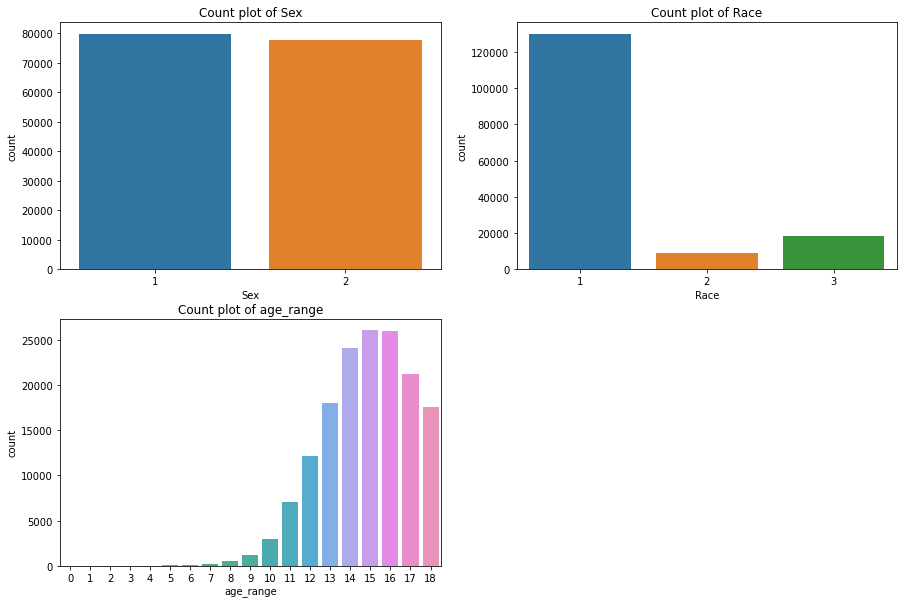

In [24]:
plt.figure(figsize=(15,10))
vars_to_look = ['Sex','Race','age_range']
for i, var in enumerate(vars_to_look):
    plt.subplot(2,2,i+1)
    if i ==3:
        plt.xticks(rotation = 90)
    sns.countplot(cancer_df[var])
    plt.title("Count plot of " + var)    

* There is more men with lung cancer than that women.

* There are significantly more white lung caner patients in the dataset. Followed by other races. Other races includes Asian  Americans and Pacific Islanders. 

* Most patients are in age ranges 15 and 16(which is ages 70-79), follwed by age range 14(which is ages 65-69) and ages 17(which is ages 80-84).

* In summary, there exists a variation across the different categories, thus we may suspect that these differences are key to understanding the variation of lung cancer ratas.

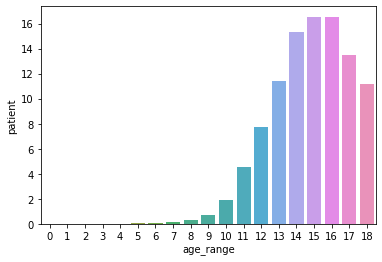

In [25]:
#We have to generate a new dataset, one that's grouped by age, to make a bar chart
#bar chart by sex
age=((cancer_df.groupby("age_range").count()/cancer_df.shape[0])*100).reset_index()
sns.barplot(x="age_range",y="patient",data=age);

### Most of the lung cancer patients appear to be older and only a few of them (less than 10%) are in the age-ranges lower than 11  (which is ages 55 and below). Therefore, for our analysis, we have decided to drop age ranges 10 and below.

In [26]:
#Drop age ranges below 10
cancer_df=cancer_df[cancer_df["age_range"]>10]

# Also make the sex variable into 1 and 0 values
cancer_df["Sex"]=cancer_df["Sex"]-1
cancer_df.head()

,Year,County,age_range,Race,Sex,patient
0,2016,Los Angeles,11,1,1,1
2,2011,Los Angeles,17,1,0,1
3,2015,Los Angeles,18,1,0,1
4,2014,Los Angeles,18,1,0,1
5,2009,Los Angeles,18,1,1,1


# Data Cleaning: Condensing and Aggregating observations

We have 158007 observations in our orginal cancer dataset. When we consider only some selected variables,like sex, race, and age-range then we have fewer unique observations. In the following we combine observations that have values for all variables identical.

We use pandas’s groupby to combine identical observations and create a new variable freq that count how many observation have the values in the corresponding row.

In [27]:
data=cancer_df.copy()
data["const"]=1
dc=data["Year County age_range Race Sex const".split()].groupby("Year County age_range Race Sex".split()).count()
dc.reset_index(inplace=True)
dc.rename(columns={'const':'freq'}, inplace=True)
print(dc.shape)
dc.head()

(14883, 6)


,Year,County,age_range,Race,Sex,freq
0,2006,Alameda,11,1,0,13
1,2006,Alameda,11,1,1,9
2,2006,Alameda,11,2,0,9
3,2006,Alameda,11,2,1,16
4,2006,Alameda,11,3,0,2


### We repeat the same steps for the population data.

In [28]:
#write a loop that will call all the SEER csv and then concat them
pop_df= pd.concat([pd.read_csv(file,delimiter=',', encoding='UTF-8') for file in POP_all]).reset_index()

#The year variable is not correctly formatted so we fix that here
pop_df['Year']= pop_df['Year']-200 +2000

p={"State-county":"County_Code",
   "Age recode with <1 year olds":"age_range",
   "Race recode (White, Black, Other)":"Race",
   "Count":"population"}

pop_df.rename(columns=p, inplace=True)
pop_df["Sex"]=pop_df["Sex"]-1

#merge the fips_data
pop_df["County_Code"]=pop_df["County_Code"].astype(int)
pop_df= pd.merge(pop_df, fips_df, on="County_Code", how="right" ).reset_index()
pop_df=pop_df[["Year","County","age_range","Race","Sex","population"]]
pop_df.head()

,Year,County,age_range,Race,Sex,population
0,2006,Los Angeles,11,1,0,24305
1,2006,Los Angeles,11,1,0,25692
2,2006,Los Angeles,11,1,0,24209
3,2006,Los Angeles,11,1,0,23542
4,2006,Los Angeles,11,1,0,22600


In [29]:
data2=pop_df.copy()
data2["const"]=1
pop=data2["Year County age_range Race Sex population".split()].groupby("Year County age_range Race Sex".split()).sum()
pop.reset_index(inplace=True)
print(pop.shape)
pop.head()

(35503, 6)


,Year,County,age_range,Race,Sex,population
0,2006,Alameda,11,1,0,29865
1,2006,Alameda,11,1,1,29574
2,2006,Alameda,11,2,0,6820
3,2006,Alameda,11,2,1,8050
4,2006,Alameda,11,3,0,12617


Now, we merge the cancer DataFrame and the population DataFrame.

In [30]:
#merge cancer and population
pd.set_option('precision', 0)
cancer_pop=pd.merge(dc, pop, on=["Year","County","age_range","Race","Sex"], how="outer").reset_index()
cancer_pop["lung_cancer_rates"]=cancer_pop["freq"]/cancer_pop["population"] *100
cancer_pop=cancer_pop.dropna()
cancer_pop=cancer_pop[["Year","County","age_range","Race","Sex","freq","population",]]
cancer_pop.head()

,Year,County,age_range,Race,Sex,freq,population
0,2006,Alameda,11,1,0,13,29865
1,2006,Alameda,11,1,1,9,29574
2,2006,Alameda,11,2,0,9,6820
3,2006,Alameda,11,2,1,16,8050
4,2006,Alameda,11,3,0,2,12617


We import the smoking data.

In [31]:
#smoking dataset
smoking=pd.read_csv('./smoking.csv')
smoking.head()

,Year,County,smoking rate
0,2006,Alameda,12
1,2006,Alpine,31
2,2006,Amador,19
3,2006,Butte,22
4,2006,Calaveras,20


In [32]:
smoking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          648 non-null    float64
 1   County        647 non-null    object 
 2   smoking rate  624 non-null    float64
dtypes: float64(2), object(1)
memory usage: 15.3+ KB


We merge the cancer and hspa DataFrames.

In [33]:
#merge with cancer_data. Now cancer, fips and hspa is merged
hspa_df["County"]=hspa_df["County"].astype(str)
cancer_pop["County"]=cancer_pop["County"].astype(str)


hspa_df['MUA_indicator'].value_counts()

1    49
Name: MUA_indicator, dtype: int64

### In order to make sure that we have a representative sample and not get cofounded by county size, we will be creating a weight for our dataset . Weighting factors are used in sampling to make samples match the population. To calculate how much weight we need, we will divide the known population percentage by the percent in the sample. 

In [34]:
#merge hspa_Df with cancer and population, and smoking data
main= pd.merge(cancer_pop, hspa_df, on="County" , how="outer")

#creating indicator variables(MUA_inidcators=1 is a MUA and 0 is not a MUA)
main['MUA_indicator']= main['MUA_indicator'].fillna(0)
main=pd.merge(main, smoking, on=["Year","County"], how="outer").reset_index()

#drop the 4 conties that were missing in the AQI DataFrame
main=main.dropna()
#calculate weight to adjust for population
#sample/frequency percentage
main["sample%"]=main['freq']/main.groupby(['Year','County'])['freq'].transform('sum')

#population percentage
main["pop%"]=main['population']/main.groupby(['Year','County'])['population'].transform('sum')


#weight
main["wgt"]=main["pop%"]/main["sample%"]

#create a weighted lung cancer frequency 
main["lc_raw"]=((main["freq"]*main["wgt"])) 

#create a lung cancer percentage (by population) that's weigted 
main["lc(w%)"]=main['lc_raw']/main.groupby(['Year','County'])['lc_raw'].transform('sum') *100
main["lc/100k"]=(main["freq"]/main['population'])*100000

main.head()

,index,Year,County,age_range,Race,Sex,freq,population,MUA_indicator,smoking rate,sample%,pop%,wgt,lc_raw,lc(w%),lc/100k
0,0,2006,Alameda,11,1,0,13,29865,1,12,2e-02,7e-02,4e+00,48,7,44
1,1,2006,Alameda,11,1,1,9,29574,1,12,1e-02,7e-02,5e+00,47,7,30
2,2,2006,Alameda,11,2,0,9,6820,1,12,1e-02,2e-02,1e+00,11,2,132
3,3,2006,Alameda,11,2,1,16,8050,1,12,2e-02,2e-02,8e-01,13,2,199
4,4,2006,Alameda,11,3,0,2,12617,1,12,3e-03,3e-02,1e+01,20,3,16


In [35]:
main["lc/100k"]=(main["freq"]/main['population'])*100000
all=main.groupby(['County','Year']).sum().reset_index()
sex=main.groupby(['County','Year','Sex']).sum().reset_index()
race=main.groupby(['County','Year','Race']).sum().reset_index()
age=main.groupby(['County','Year','age_range']).sum().reset_index()

In [36]:
dataset_test=cancer_df.copy()

In [37]:
dataset_test.to_csv('all.csv')

Now we merge all our DataFrames to get one DataFrame to work from.

In [38]:
#merge the AQI dataset to the weighted cancer dataset
dataset=pd.merge(main, aqi_df, on=["Year","County"],how="outer").reset_index()
dataset=dataset[dataset['County'] !="California"]
dataset=dataset.dropna()
dataset.head()

,level_0,index,Year,County,age_range,Race,Sex,freq,population,MUA_indicator,...,Days_SO2,Days_PM2.5,Days_PM10,% Good_Days,% Moderate_Days,% Unhealthy_for_Sensitive_Groups_Days,% Unhealthy_Days,% Very_Unhealthy_Days,% Hazardous_Days,% PM2.5_Days
0,0,0,2006,Alameda,11,1,0,13,29865,1,...,,185,,6,34,5,1,,,51
1,1,1,2006,Alameda,11,1,1,9,29574,1,...,,185,,6,34,5,1,,,51
2,2,2,2006,Alameda,11,2,0,9,6820,1,...,,185,,6,34,5,1,,,51
3,3,3,2006,Alameda,11,2,1,16,8050,1,...,,185,,6,34,5,1,,,51
4,4,4,2006,Alameda,11,3,0,2,12617,1,...,,185,,6,34,5,1,,,51


In [39]:
dataset.describe()

,level_0,index,Year,age_range,Race,Sex,freq,population,MUA_indicator,smoking rate,...,Days_SO2,Days_PM2.5,Days_PM10,% Good_Days,% Moderate_Days,% Unhealthy_for_Sensitive_Groups_Days,% Unhealthy_Days,% Very_Unhealthy_Days,% Hazardous_Days,% PM2.5_Days
count,15017,15017,15017,15017,2e+04,2e+04,15017,15017,2e+04,15017,...,2e+04,15017,15017,15017,15017,15017,2e+04,2e+04,2e+04,15017
mean,7508,7604,2011,15,2e+00,5e-01,10,7930,9e-01,14,...,3e-01,121,7,53,35,8,3e+00,2e-01,3e-02,34
std,4335,4366,3,2,8e-01,5e-01,16,18222,3e-01,4,...,3e+00,70,21,26,17,9,5e+00,8e-01,2e-01,21
min,0,0,2006,11,1e+00,0e+00,1,1,0e+00,6,...,0e+00,0,0,3,0,0,0e+00,0e+00,0e+00,0
25%,3754,3839,2008,13,1e+00,0e+00,2,842,1e+00,11,...,0e+00,73,0,33,23,1,0e+00,0e+00,0e+00,20
50%,7508,7624,2011,15,1e+00,0e+00,4,2608,1e+00,13,...,0e+00,129,1,56,36,5,3e-01,0e+00,0e+00,36
75%,11262,11378,2014,16,2e+00,1e+00,11,7414,1e+00,16,...,0e+00,165,6,73,47,13,3e+00,0e+00,0e+00,46
max,15017,15158,2016,18,3e+00,1e+00,126,245620,1e+00,31,...,6e+01,355,354,100,76,42,2e+01,7e+00,7e+00,100


We can see that the average age range is 15, which is ages between 70-74. As confirmed earlier, most of our lung cancer patients are older people.

### Now we will construct histograms to see the distribution of some variables.

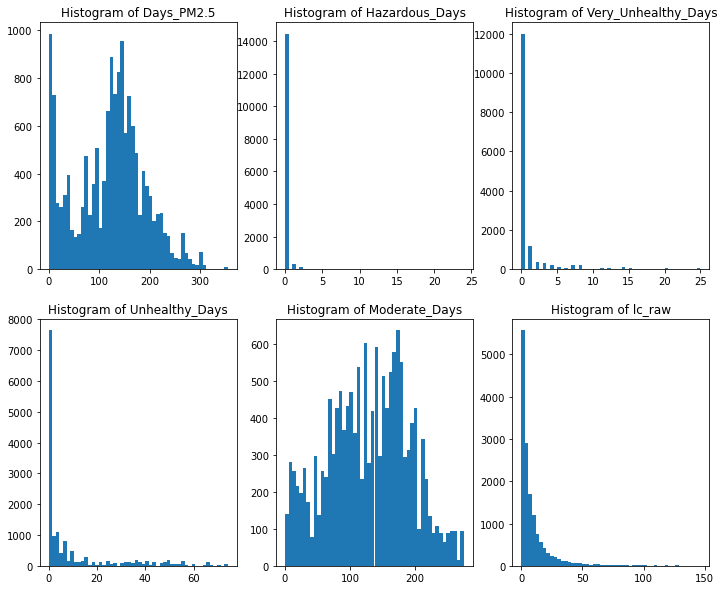

In [40]:
plt.figure(figsize=(12,10))
vars_to_plot = ['Days_PM2.5','Hazardous_Days','Very_Unhealthy_Days','Unhealthy_Days','Moderate_Days','lc_raw']
for i, var in enumerate(vars_to_plot):
    plt.subplot(2,3,i+1)
    plt.hist(dataset[var],50)
    title_string = "Histogram of " + var
    plt.title(title_string)

* Histogram PM2.5 days is slightly skewed right. That means that some counties have very high % of PM2.5 while the rest have lower rates. 
* The histograms Hazardous days, very_unhealthy days and unhealthy days are sparse.This tells us most counties have very low rates or no hazardous, very unhealthy, and unhealthy days at all. 
* Histogram of moderate days is a normal distibution. So most counties have the average number of moderate days. 
* Lastly, Histogram of lung cancer (weighted) is right skewed, which means some counties have very high rates while most have low rates.

### What about smoking and lung cancer trends over the past 10 years?

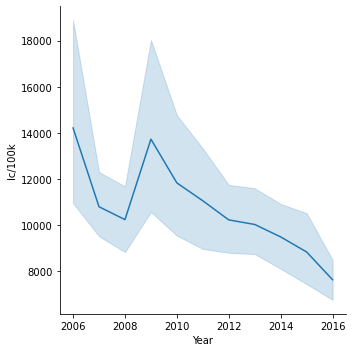

In [41]:
all=main.groupby(['County','Year']).sum().reset_index()
sns.relplot(x='Year',y="lc/100k",data=all,kind='line')

It looks like lung cancer incidencies have been going down.

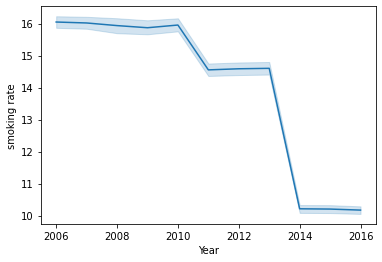

In [42]:
sns.lineplot(x='Year',y = 'smoking rate' , data = dataset)

It looks like there has been a sharp decrease in smoking rate.

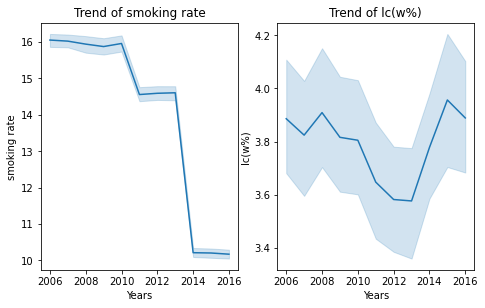

In [43]:
plt.figure(figsize=(12,10))
vars_to_plot = ['smoking rate','lc(w%)']
for i, var in enumerate(vars_to_plot):
    plt.subplot(2,3,i+1)
    sns.lineplot(x='Year',y = var , data = dataset)
    title_string = "Trend of " + var
    plt.xlabel('Years')
    plt.title(title_string)

### Now let's look at some scatter plot to observe relationships.

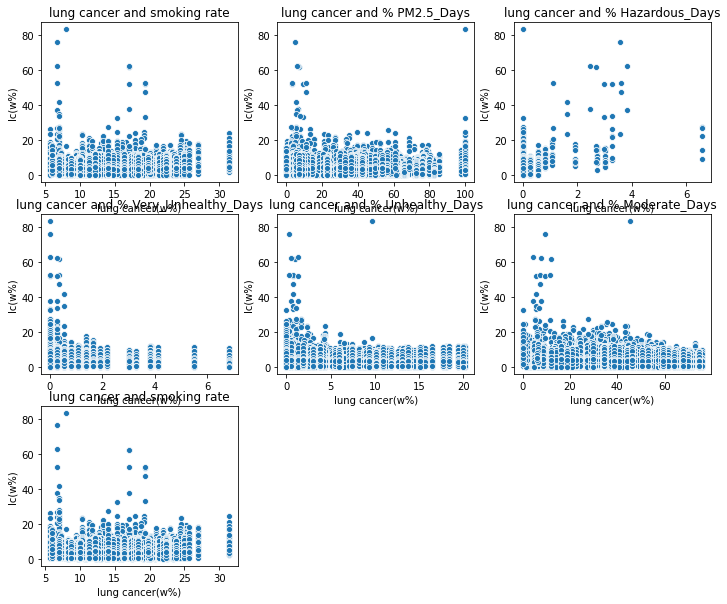

In [44]:
plt.figure(figsize=(12,10))
vars_to_plot = ["smoking rate",'% PM2.5_Days','% Hazardous_Days','% Very_Unhealthy_Days','% Unhealthy_Days','% Moderate_Days',"smoking rate"]
for i, var in enumerate(vars_to_plot):
    plt.subplot(3,3,i+1)
    sns.scatterplot(x=var ,y = "lc(w%)" , data = dataset)
    title_string = "lung cancer and " + var
    plt.xlabel('lung cancer(w%)')
    plt.title(title_string)

Although,some variables, like smoking, seem to be posetively correlated with lung cancer incidencies. There doesn't seem to be a strong correlation lung cancer incidencies and most of the variables.

### Let's look at time trends for air quality measures.

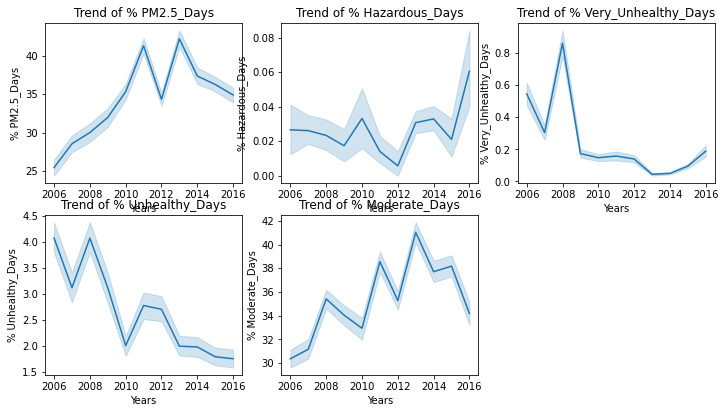

In [45]:
plt.figure(figsize=(12,10))
vars_to_plot = ['% PM2.5_Days','% Hazardous_Days','% Very_Unhealthy_Days','% Unhealthy_Days',
                '% Moderate_Days']
for i, var in enumerate(vars_to_plot):
    plt.subplot(3,3,i+1)
    sns.lineplot(x='Year',y = var , data = dataset)
    title_string = "Trend of " + var
    plt.xlabel('Years')
    plt.title(title_string)

* We see that % of PM2.5 days, very unhealthy days,unhealthy days and moderate days have for the most part been decreasing in the past decade while hazardous days are increasing.

#### Let's look at Lung cancer incidencies by sex, race, and age group.

### Looks like the cancer incidencies has been increasing for Black people since 2015. Decreasing for the other two.

<Figure size 864x720 with 0 Axes>

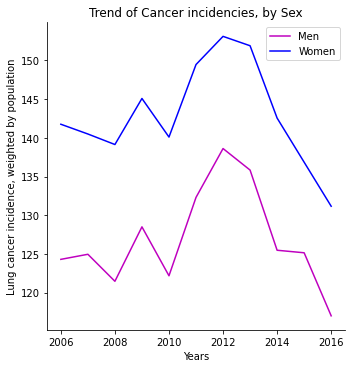

In [46]:
#lung cancer by sex
sex=main.copy()
sex=sex.groupby(["Year","County","Sex"]).sum().reset_index()
plt.figure(figsize=(12,10))

g=sns.relplot(x='Year',y = "lc_raw" , data = sex, hue="Sex",
              kind="line",ci=None, legend=False,palette=["m","b"])
plt.legend(['Men','Women'])
plt.title("Trend of Cancer incidencies, by Sex" )
plt.xlabel('Years')
plt.ylabel('Lung cancer incidence, weighted by population')
plt.show()

Looks like cancer incidence is going down for both men and women.

<Figure size 864x720 with 0 Axes>

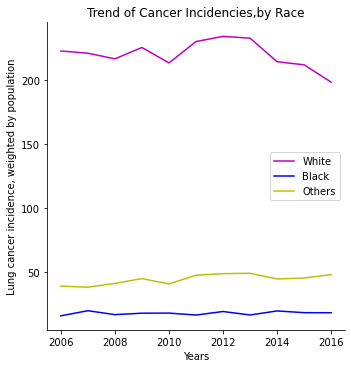

In [47]:
#lung cancer by race
race=main.copy()
race=race.groupby(["Year","County","Race"]).sum().reset_index()
plt.figure(figsize=(12,10))

g=sns.relplot(x='Year',y = "lc_raw", data = race,
              hue="Race", kind="line",ci=None,legend=False,
             palette=["m","b","y"])
plt.title("Trend of Cancer Incidencies,by Race" )
plt.xlabel('Years')
plt.ylabel('Lung cancer incidence, weighted by population')
plt.legend(["White","Black","Others"])

Looks like incidencies is going down for white people. other races have a slight increase, while Black people have a constant rate.

### In earlier years, Men have higher rates of lung cancer but in later years women have higher rates. (look up articles on this).

<Figure size 864x720 with 0 Axes>

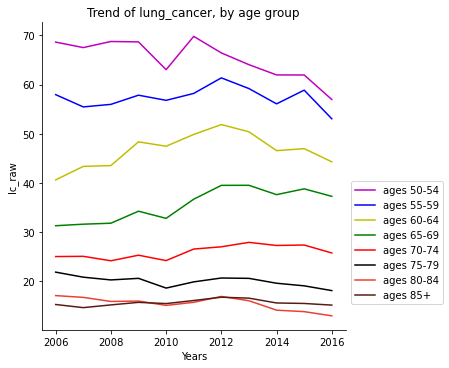

In [48]:
#lung cancer by age group
age=main.copy()
age=age.groupby(["Year","County","age_range"]).sum().reset_index()
#seaborn doesn't seem to like category variables so we have to change year into an integer for the plot
dataset["age_range"]=dataset["age_range"].astype(int)

plt.figure(figsize=(12,10))

g=sns.relplot(x='Year',y = "lc_raw" , data = age,
            hue="age_range", kind="line",ci=None, legend=False,
              palette=["m","b","y",'g','r','black',"#eb4034","#591a15"])
plt.legend(['ages 50-54','ages 55-59','ages 60-64','ages 65-69','ages 70-74','ages 75-79','ages 80-84','ages 85+'], bbox_to_anchor=(1,0.5))
#g.fig.get_axes()[0].legend(loc='lower left')
plt.title("Trend of lung_cancer, by age group")
plt.xlabel('Years')
plt.show()

Most of the age groups have a decrease in lung cancer incidence.

### To add to our earlier analysis, we can make scatter plots for our catagorical variables to see their correlation with lung cancer incidencies.

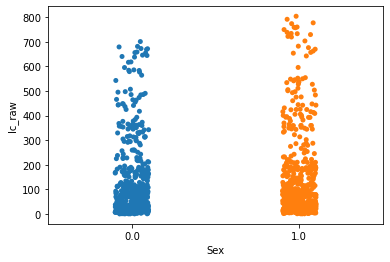

In [49]:
sns.stripplot(x="Sex",y="lc_raw", data=sex);

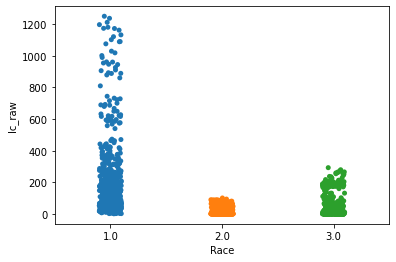

In [50]:
sns.stripplot(x="Race",y="lc_raw", data=race);

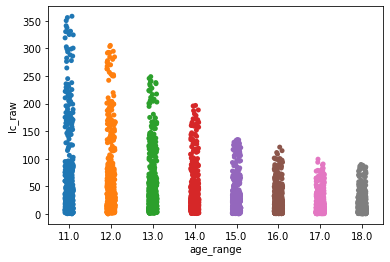

In [51]:
sns.stripplot(x="age_range",y="lc_raw", data=age);

### We can make a correlation matrix to see the correlation between lung cancer incidencies and other variables. 

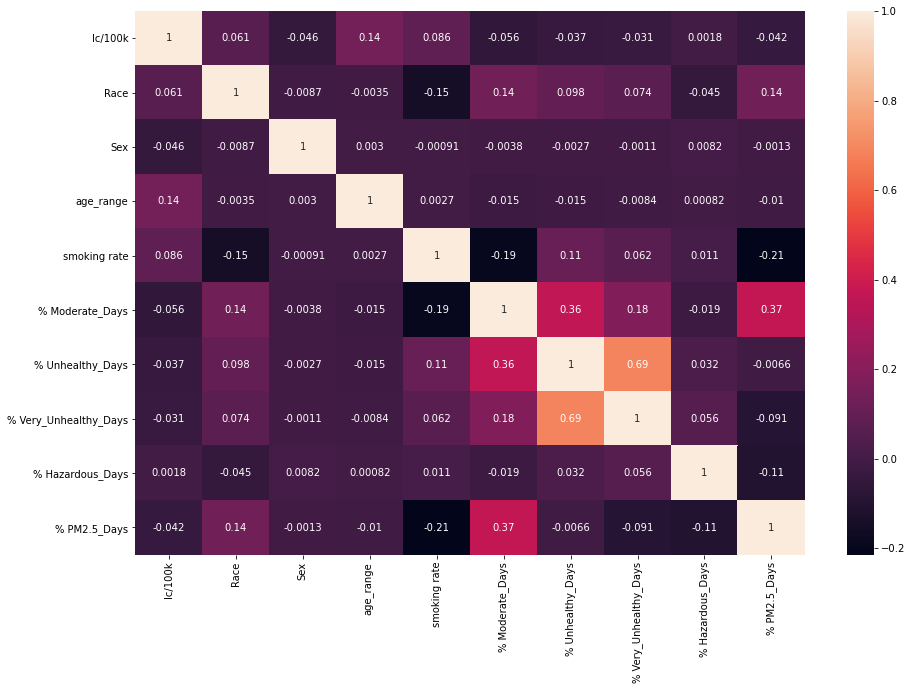

In [52]:
# calculate correlation matrix for all 
plt.subplots(figsize=(15,10))
corr = dataset[['lc/100k',"Race","Sex","age_range",'smoking rate','% Moderate_Days','% Unhealthy_Days',
                        '% Very_Unhealthy_Days','% Hazardous_Days','% PM2.5_Days']].corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True);

####  Lung cancer incidence is positively correlated with smoking, sex, and hazardous days. In contrast, lung cancer lung cancer incidence is negatively correlated with race, age, moderate days, unhealthy days, very unhealthy days, and PM2.5 days.

### Do counties who have high incidence rates also have high hazardous days?

Let's see which are the top five counties that have been in the top 10 of cancer incidencies and hazardous days over the years.

In [53]:
result = (
    dataset.sort_values('lc(w%)', ascending=False) #Sort the dataframe by lung cancer rate in descending order
        .groupby('Year').head(10) #For each year, get the top 10 counties
        .groupby('County').size() #For each country, count how many times it appears on the top-10 list
        .sort_values(ascending=False)#Sort the result descendingly
)
result.head()

County
Mono          25
San Benito    17
Plumas        17
Trinity       10
Glenn         10
dtype: int64

In [54]:
result = (
    dataset.sort_values('% Hazardous_Days', ascending=False) #Sort the dataframe by lung cancer rate in descending order
        .groupby('Year').head(10) #For each year, get the top 10 counties
        .groupby('County').size() #For each country, count how many times it appears on the top-10 list
        .sort_values(ascending=False)#Sort the result descendingly
)
result.head()

County
Inyo           52
Mono           35
Riverside      15
San Joaquin     8
dtype: int64

***It looks like the county mono has high lung cancer incidencies and hazardous days.***

# Regression Model

In our analysis above, since we identified some independent variables that are correlated with lung cancer incidencies ( the dependent variable), a linear model can be used to capture this relationship quantitatively. A linear model does this by finding a line that best fits the data points. Thus, we are going to construct a multivariate linear regression.

***The null hypothesis we will be testing is: Air quality has no effect on lung cancer incidencies.***


In [55]:
#We need to create dummy variables for our catagorical variables
dataset_reg=dataset.copy()
dataset_reg=pd.get_dummies(dataset_reg,columns=["Sex","Race","MUA_indicator"],drop_first=True)
names={"Sex_1.0":"female",
      "Race_2.0":"Black",
      "Race_3.0":"Others",
      "MUA_indicator_1.0":"MUA indicator",
      "freq":"const"
      }
dataset_reg.rename(columns=names,inplace=True)
dataset_reg=pd.get_dummies(dataset_reg,columns=["age_range"])
ages={"age_range_11":"ages_50-54",
       "age_range_12":"ages_55-59",
       "age_range_13":"ages_60-64",
       "age_range_14":"ages_65-69",
       "age_range_15":"ages_70-74",
       "age_range_16":"ages_75-79",
       "age_range_17":"ages_80-84"
      }
dataset_reg.drop("age_range_18",axis=1,inplace=True)
#dataset_reg['lung_cancer(w%)']=dataset_reg['lung_cancer(w%)']*100
dataset_reg.rename(columns=ages,inplace=True)
dataset_reg.head()

,level_0,index,Year,County,const,population,smoking rate,sample%,pop%,wgt,...,Black,Others,MUA indicator,ages_50-54,ages_55-59,ages_60-64,ages_65-69,ages_70-74,ages_75-79,ages_80-84
0,0,0,2006,Alameda,13,29865,12,2e-02,7e-02,4e+00,...,0,0,1,1,0,0,0,0,0,0
1,1,1,2006,Alameda,9,29574,12,1e-02,7e-02,5e+00,...,0,0,1,1,0,0,0,0,0,0
2,2,2,2006,Alameda,9,6820,12,1e-02,2e-02,1e+00,...,1,0,1,1,0,0,0,0,0,0
3,3,3,2006,Alameda,16,8050,12,2e-02,2e-02,8e-01,...,1,0,1,1,0,0,0,0,0,0
4,4,4,2006,Alameda,2,12617,12,3e-03,3e-02,1e+01,...,0,1,1,1,0,0,0,0,0,0


In [56]:
# Fit and summarize OLS model
model = sm.OLS(endog=dataset_reg['lc/100k'],
               exog=dataset_reg[["const",'smoking rate',"female","Black","Others",
                                    "ages_50-54","ages_55-59","ages_60-64","ages_65-69","ages_70-74",
                                    "ages_75-79","ages_80-84","MUA indicator",
                                    "% Moderate_Days","% Unhealthy_Days","% Good_Days","% Hazardous_Days","% PM2.5_Days"]]).fit()

print(model.summary())

AttributeError: module 'statsmodels.formula.api' has no attribute 'OLS'

***Note:** 
For our dummy variables, men, white, ages 85+ are the references.
MUA is a proxy for socioeconomic status.

## Interpreting the regression output:

### Coefficients
* Holding sex, race, age, and air quality constant, on average, If the smoking rates goes up by 1%, the cancer rate goes up 0.05%, on average. 

* Holding sex, race, age, and air quality constant, on average, women have 0.41% higher lung cancer incidencies than men.

* Holding sex, race, age, and air quality constant, on average, Black people have 5.93% less lung cancer incidencies than white people.

* Holding sex, race, age, and air quality constant, on average, other races have 5.18% less lung cancer incidencies than white people.

* Holding sex, race, age, and air quality constant, on average, ages 50-54 have 4.52% higher lung cancer incidencies than other age 85+.

* Holding sex, race, age, and air quality constant, on average, ages 55-59 have 4.22% higher lung cancer incidencies than other age 85+.

* Holding sex, race, age, and air quality constant, on average, ages 60-64 have 3.61% higher lung cancer incidencies than other age 85+.

* Holding sex, race, age, and air quality constant, on average, ages 65-69 have 2.62% higher lung cancer incidencies than other age 85+.

* Holding sex, race, age, and air quality constant, on average, ages 70-74 have 1.53% higher lung cancer incidencies than other age 85+.

* Holding sex, race, age, and air quality constant, on average, ages 75-79 have 0.79% higher lung cancer incidencies than other age 85+.

* Holding sex, race, age, and air quality constant, on average, ages 80-84 have 0.17% higher lung cancer incidencies than other age 85+.

* Holding sex, race, age, and air quality constant, on average, Medically underserved areas (MUA) have 1.1% less cancer incidencies than non-MUA.

* Holding sex, race, age, and air quality constant, on average, If the moderate days goes up by 1%, the lung cancer incidencies goes up by 0.04%.

* Holding sex, race, age, and air quality constant, on average, If the unhealthy days goes up by 1%, the lung cancer incidencies goes up by 0.01%.

* Holding sex, race, age, and air quality constant, on average, If the hazardous days goes up by 1%, the lung cancer incidencies goes up by 4.13%.

* Holding sex, race, age, and air quality constant, on average, If the PM2.5 days goes up by 1%, the lung cancer incidencies goes up by 0.007%.

### P-values
* All of the coefficients p-values are less than 0.05, which means they are statistically significant.Thus, we reject the null hypothesis and we can say there is strong evidence that air quality does has an effect on lung cancer.

### The coefficient of multiple determination (R^2)

* The R^2 is 0.832. It means that 83.2% of lung cancer incidencie variariation can be explained by race, sex, age, smoking rate, and air quality measures. In other words, our equation fits the data pretty well.

## Conclusion

Our analysis looked at the air quality measures and their relationship to lung cancer incidencies. Adjusting for sex, race, age, and socioeconomic status, we found that their is strong evidence that air quality has an effect on lung cancer incidencies.